In [1]:
#imports

import os
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
from numpy import reshape
import re
%matplotlib inline

In [2]:
os.chdir("/Users/andrewcaffey/Documents/Projects/Data/PCPP/parts/fans/parts/")
part_list = []
comments = []
for i in os.listdir(os.getcwd()):
    a = open(i, 'r')
    #print a.read()
    b = BeautifulSoup(a)

    #basic info
    if b.find('h4', attrs={'class':'kind'}) != None:
        kind = b.find('h4', attrs={'class':'kind'}).text
        part_name = b.find('h1', attrs={'class':'name'}).text
        link = b.find('input', attrs={'name':'url'})['value']
        info_dict = {'Kind':kind, 'Name':part_name, 'Link': link}

        #prices
        if b.find_all('td', attrs={'class':'base'}) != None:
            price_list = b.find_all('td', attrs={'class':'base'})
            price_list = [float(x.text.strip('$')) for x in price_list]
            #average_price = sum(price_list)/len(price_list)
            price_dict = {'Prices':price_list,}

        #specs
        spec_labels = b.find('div', attrs={'class':'specs block'}).find_all('h4')
        spec_labels = [x.contents[0] for x in spec_labels]
        spec_values = str(b.find('div', attrs={'class':'specs block'}))

        vals = [x.strip().split('</h4>')[1].strip('\n').strip() for x in spec_values.split("<h4>")[1:]]
        vals[-1] = vals[-1].split('\n')[0]
        spec_values = vals

        spec_values = spec_values[0:len(spec_labels)+1]
        spec_dict = {spec_label:spec_value for spec_label, spec_value in zip(spec_labels,spec_values)}

        part_dict = dict(spec_dict.items() + info_dict.items() + price_dict.items())
        part_list.append(part_dict)

        #reviews
    reviews = b.find('div', attrs={'class':'part-reviews'})
    if reviews != None:
        reviews = reviews.find_all('div',attrs={'class':'part-review-block'})
        star_list = [len(reviews[x].find('ul',attrs={'class':'stars'}).find_all('li',attrs={'class':'full-star'})) for x in range(len(reviews))]

        comment_text_list = b.find_all('div', attrs={'class':'comment-message markdown'})
        comment_text_list = [comment_text_list[x].find_all('p') for x in range(len(comment_text_list))]

        comment_text_list_clean = []
        for i, x in enumerate(comment_text_list):
            comment = ""
            for y in x:
                try:
                    comment += y.contents[0] + " "
                except:
                    pass
            comment_text_list_clean.append(comment)

        

        review = zip(star_list, comment_text_list_clean)
        
        comments.append(review)

    a.close()
    b.decompose()

In [3]:
df = pd.DataFrame(part_list)

In [4]:
#standard

#average price
df['avg'] = [sum(x)/len(x) if len(x)>0 else 0 for x in df.Prices]

#short_link
df['short_link'] = [x.split('/')[-1] for x in df.Link]

In [5]:
#size
df['Size'] = [x if x!= 'N/A' else '0' for x in df.Size]
df['fan_size'] = [float(x.strip('mm')) if type(x)==str else 0 for x in  df.Size] 

In [6]:
#airflow
df['air_flow'] = df['Air Flow']
df.air_flow = [re.sub(r'[a-zA-z]+', '', x) if type(x)==str else '0' for x in df.air_flow]
df.air_flow = [x if x != '-' else '0' for x in df.air_flow]
df['max_flow'] = [float(x.split('-')[1]) if '-' in x else x for x in df.air_flow]
df['min_flow'] = [float(x.split('-')[0].strip()) if type(x)==str else 0 for x in df.air_flow]

In [7]:
#rpm

df['rpm'] = [x for x in df['RPM']]
df.rpm = [re.sub(r'[A-Z]+', '', x).strip('-') if type(x)==str else '0 - 0' for x in df.rpm]
df['rpm_min'] = [float(x.split('-')[0]) if '-' in x else float(x) for x in df.rpm]
df['rpm_max'] = [float(x.split('-')[1]) if '-' in x else float(x) for x in df.rpm]

In [8]:
#noise

df['noise'] = [x for x in df['Noise Level']]
df.noise = [x if type(x)==str else '0 dbA' for x in df.noise]

df.noise = [re.sub(r'[A-Z]+', '', x.upper()) if '-' not in x else re.sub(r'[A-Z]+', '', x.upper()) for x in df.noise]
df.noise = ['0' if x=='-' else x for x in df.noise]
df.noise = [float(x) if '-' not in x else float(x.split('-')[1]) for x in df.noise]

#led
df['has_LED'] = ["Yes" if type(x)==str else 'No' for x in df['LED Color']]

#static pressure
df['static_pressure'] = [float(x.split(' ')[0]) if type(x)==str else 0 for x in df['Static Pressure']]

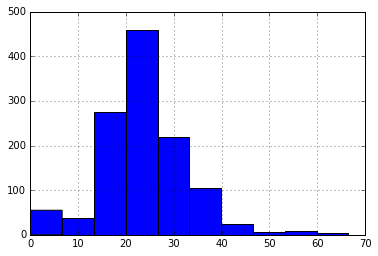

In [73]:
df.noise.hist()

In [9]:
#save df to local csv file
df.to_csv('fan_csv_FINAL_final.csv', encoding='utf-8', index=False)

In [51]:
df = pd.read_csv('fan_csv.csv')